In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt


C:\Users\Yang\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Define Functions

In [2]:
#normalize data frame
def normalize(df):
    #Number of photos
    df["num_photos"] = df["photos"].apply(len)
    #Number of features
    df["num_features"] = df["features"].apply(len)
    #Number of description words
    df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
    #Created time 
    df["created"] = pd.to_datetime(df["created"])
    df["created_year"] = df["created"].dt.year
    df["created_month"] = df["created"].dt.month
    df["created_day"] = df["created"].dt.day
    #Manager ID
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df['manager_id'].values))
    df['manager_id'] = lbl.transform(list(df['manager_id'].values))
    #Building ID
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df['building_id'].values))
    df['building_id'] = lbl.transform(list(df['building_id'].values))

#add manager_skill
def manager_skill(x_train, y_train):
    temp = pd.concat([x_train.manager_id, pd.get_dummies(y_train)], axis=1).groupby('manager_id').mean()
    temp['count'] = x_train.groupby('manager_id').count().iloc[:,0]

    #compute skill
    temp['manager_skill'] = temp['high']*2 + temp['medium']
    
    return temp
    
#mean skill values
def mean_skill(temp):
    # get ixes for unranked managers...
    unranked_managers_ixes = temp['count']<5
    # ... and ranked ones
    ranked_managers_ixes = ~unranked_managers_ixes

    # compute mean values from ranked managers and assign them to unranked ones
    mean_values = temp.loc[ranked_managers_ixes, ['high','low','medium','manager_skill']].mean()
    # compute for unranked_managers_ixes
    temp.loc[unranked_managers_ixes,['high','low','medium','manager_skill']] = mean_values.values
    
    return mean_values

#price_per_bedroom
def price_per_bedroom(x):
    x['price_per_bedroom']=0;
    x.loc[:, 'price_per_bedroom'] = x.apply(lambda row: valuation_formula(row['bedrooms'], row['price']), axis=1)

#bedroom/bathroom
def bedratiobath(x):
    x['bed_bath_ratio']=0;
    x.loc[:, 'bed_bath_ratio'] = x.apply(lambda row: valuation_formula(row['bathrooms'], row['bedrooms']), axis=1)
    
def valuation_formula(x, y):
    if x>0:
        return y/x
    else:
        return y

# PreProcessing

In [3]:
#Read data from file
df = pd.read_json("train.json")
normalize(df)

In [4]:
initial_features = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day", "manager_id","building_id"]

x = df[initial_features]
target_num_map = {'high':0, 'medium':1, 'low':2}
y = np.array(df['interest_level'].apply(lambda x: target_num_map[x]))

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33)

In [5]:
print(x_train.head())
x_train.to_csv("xtrain.csv")

        bathrooms  bedrooms  latitude  longitude  price  num_photos  \
116290        1.0         0   40.7568   -73.9982   2500           7   
45914         2.0         2   40.7627   -73.9769   6755           7   
62255         1.0         1   40.7228   -73.9826   2870           7   
24616         1.0         1   40.7687   -73.9867   2500           3   
69828         1.0         1   40.7490   -73.9954   2600           7   

        num_features  num_description_words  created_year  created_month  \
116290            12                    106          2016              4   
45914              5                     75          2016              5   
62255              7                    153          2016              5   
24616              1                     32          2016              6   
69828              2                     37          2016              5   

        created_day  manager_id  building_id  
116290            6        1298         4424  
45914            30   

In [6]:
features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day", 'high','low','medium',
                   "building_id",'manager_id']

# Make Prediction
## RandomForestClassifier

In [83]:
these_features = [f for f in features_to_use if f not in ["created_year", 'high','low','medium']]

# Random Forest Classification Tree
clf = RandomForestClassifier(n_estimators=2000)
clf.fit(x_train[these_features], y_train)
y_val_pred = clf.predict_proba(x_val[these_features])
log_loss(y_val, y_val_pred)

0.61228117120163772

In [84]:
preds = clf.predict(x_val[these_features])

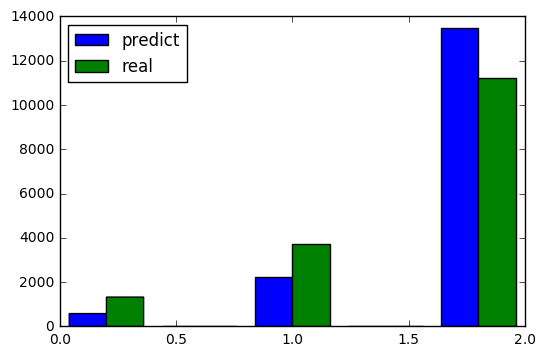

In [85]:
bins = np.linspace(0, 2, 6)
data = np.vstack([preds, y_val]).T
plt.hist(data, bins, alpha=1, label=['predict','real'])
plt.legend(loc='upper left')
plt.show()

In [86]:
from sklearn.metrics import classification_report

target_names = ['high', 'medium', 'low']
print(classification_report(preds, y_val, target_names=target_names))

             precision    recall  f1-score   support

       high       0.24      0.54      0.33       581
     medium       0.29      0.49      0.37      2236
        low       0.93      0.78      0.85     13470

avg / total       0.82      0.73      0.76     16287



In [87]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, preds)

array([[  313,   482,   531],
       [  194,  1091,  2447],
       [   74,   663, 10492]])

In [88]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

y = label_binarize(y_val, classes=[0,1,2])
score = label_binarize(preds, classes=[0,1,2])
# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()

for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i],
                                                        score[:, i])
    average_precision[i] = average_precision_score(y[:, i], score[:, i])

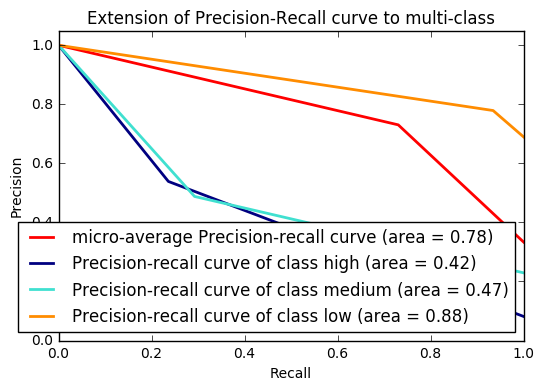

In [89]:
# Plot Precision-Recall curve for each class
from itertools import cycle
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(),score.ravel())
average_precision["micro"] = average_precision_score(y, score,average="micro")

plt.clf()
plt.plot(recall["micro"], precision["micro"], color='red', lw=2,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(len(target_names)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(target_names[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

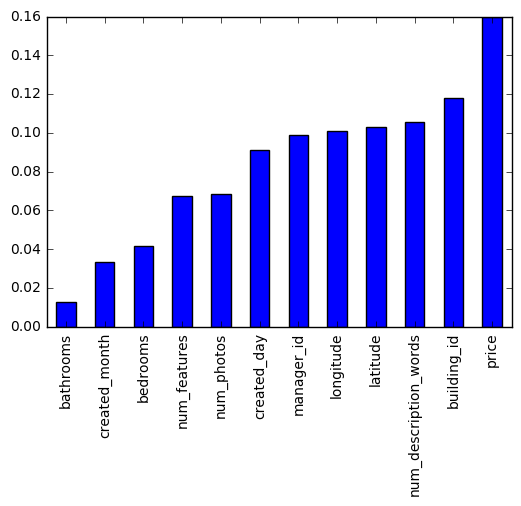

In [90]:
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

In [96]:
y = label_binarize(y_val, classes=[0,1,2])
score = label_binarize(preds, classes=[0,1,2])

print(y[:,1])
print(score[:,1])

[1 0 0 ..., 1 0 0]
[0 0 0 ..., 0 0 0]


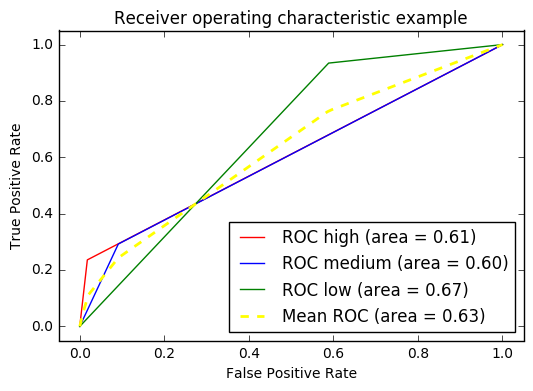

In [103]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
labels = ['high','medium','low']
colors = ['red', 'blue', 'green', 'yellow']

for i in range(3):
    fpr, tpr, _ = roc_curve(y[:,i], score[:,i])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, color=colors[i],
             label='ROC %s (area = %0.2f)' % (labels[i], roc_auc))

mean_tpr /= 3
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='yellow', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Adaboost

In [104]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=2000)
clf.fit(x_train[these_features], y_train)
y_preds = clf.predict_proba(x_val[these_features])
log_loss(y_val, y_preds)

1.097542558821581

In [105]:
preds = clf.predict(x_val[these_features])

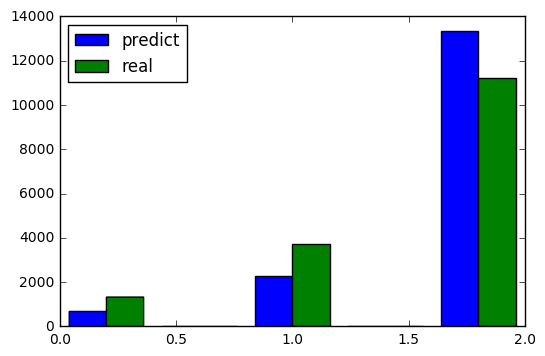

In [106]:
bins = np.linspace(0, 2, 6)
data = np.vstack([preds, y_val]).T
plt.hist(data, bins, alpha=1, label=['predict','real'])
plt.legend(loc='upper left')
plt.show()

In [107]:
from sklearn.metrics import classification_report

target_names = ['high', 'medium', 'low']
print(classification_report(preds, y_val, target_names=target_names))

             precision    recall  f1-score   support

       high       0.26      0.51      0.35       677
     medium       0.29      0.47      0.36      2289
        low       0.93      0.78      0.85     13321

avg / total       0.81      0.73      0.76     16287



In [108]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, preds)

array([[  347,   487,   492],
       [  228,  1084,  2420],
       [  102,   718, 10409]])

In [109]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

y = label_binarize(y_val, classes=[0,1,2])
score = label_binarize(preds, classes=[0,1,2])
# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()

for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i],
                                                        score[:, i])
    average_precision[i] = average_precision_score(y[:, i], score[:, i])

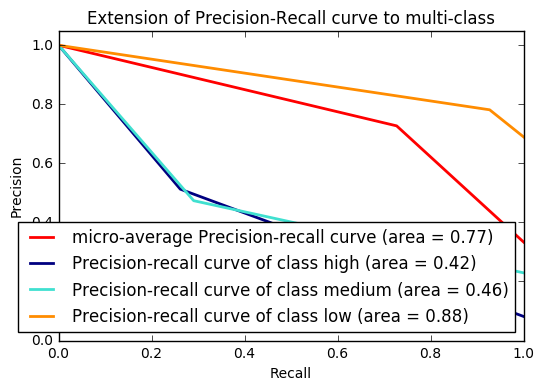

In [110]:
# Plot Precision-Recall curve for each class
from itertools import cycle
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(),score.ravel())
average_precision["micro"] = average_precision_score(y, score,average="micro")

plt.clf()
plt.plot(recall["micro"], precision["micro"], color='red', lw=2,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(len(target_names)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(target_names[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

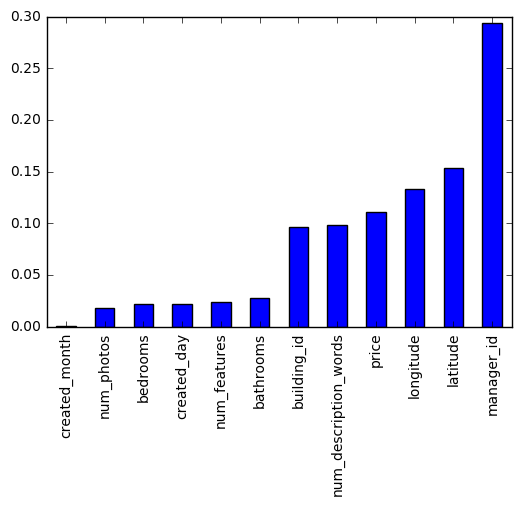

In [111]:
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

In [112]:
y = label_binarize(y_val, classes=[0,1,2])
score = label_binarize(preds, classes=[0,1,2])

print(y[:,2])
print(score[:,2])

[0 1 0 ..., 0 1 1]
[1 0 1 ..., 0 0 1]


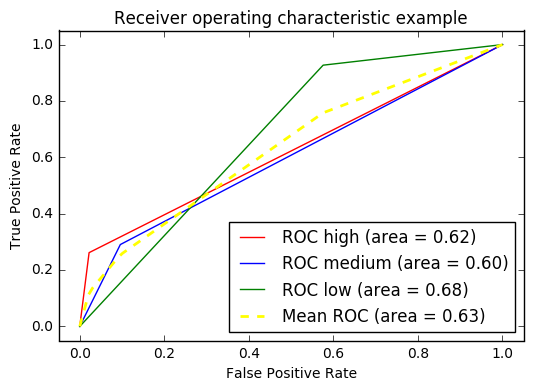

In [113]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
labels = ['high','medium','low']
colors = ['red', 'blue', 'green', 'yellow']

for i in range(3):
    fpr, tpr, _ = roc_curve(y[:,i], score[:,i])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, color=colors[i],
             label='ROC %s (area = %0.2f)' % (labels[i], roc_auc))

mean_tpr /= 3
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='yellow', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()